In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
import datetime
import statsmodels

# Ice Cream Production Data

In [2]:
#read data
df_ice_cream = pd.read_csv('ice_cream.csv')

In [3]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [4]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [5]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

In [6]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

In [7]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [8]:
#show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


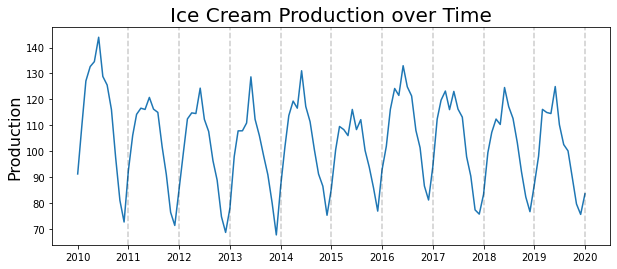

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [10]:
df_ice_cream.describe()

,production
count,121.000000
mean,103.607036
std,16.914680
min,67.803100
25%,90.998200
50%,107.315200
75%,116.136500
max,143.951900


# ACF

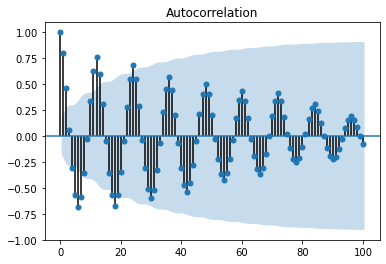

In [11]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

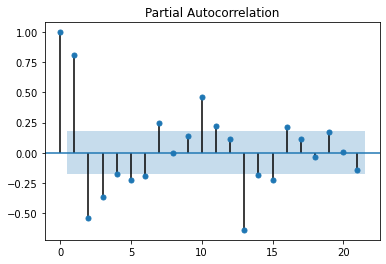

In [12]:
pacf_plot = plot_pacf(df_ice_cream.production)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13

In [35]:
# Get training and testing sets
train_end = datetime.date(2016,12,1)
test_end = datetime.date(2019,12,1)

train_data= df_ice_cream.production[:train_end]
test_data= df_ice_cream.production[train_end+ datetime.timedelta(days = 1):test_end]

In [24]:
#Fit the AR model

In [36]:

model = statsmodels.tsa.arima_model.ARMA(train_data, order=(3,0))

C:\Users\KyleDu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [43]:
model_fit = model.fit()

In [44]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Wed, 10 Feb 2021   AIC                            598.015
Time:                        17:49:29   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

In [45]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [46]:
predictions = model_fit.predict(start= pred_start_date, end = pred_end_date)
residual = test_data - predictions

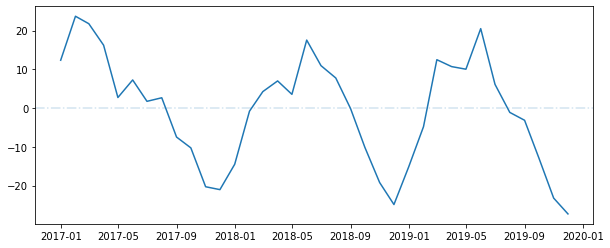

In [54]:
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.axhline(0, linestyle = "-.", alpha = 0.2)


In [57]:
prediction_rolling = pd.Series()

for end_date in test_data.index:
    train_data = df_ice_cream.production[:end_date-datetime.timedelta(days=1)]
    model = statsmodels.tsa.arima_model.ARMA(train_data, order=(3,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    prediction_rolling.loc[end_date] = pred.loc[end_date]

<ipython-input-57-8dd9bc17ac28>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction_rolling = pd.Series()
C:\Users\KyleDu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\KyleDu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\KyleDu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\KyleDu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: N

In [58]:
residuals_rolling = test_data - prediction_rolling

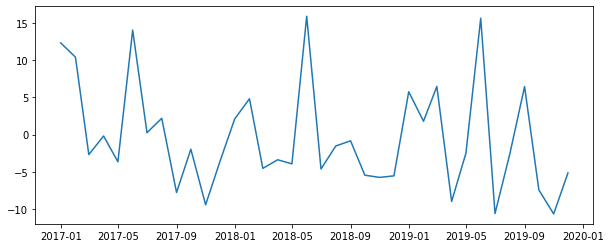

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(residuals_rolling)

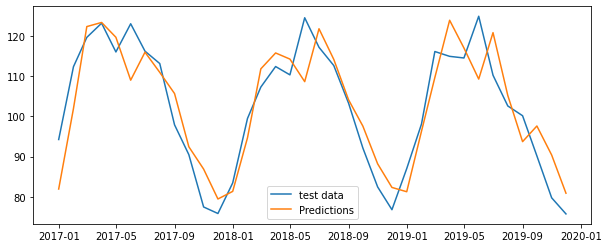

In [66]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(prediction_rolling)

plt.legend(["test data", "Predictions"])